In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

In [2]:
import torch
import numpy as np
import pandas as pd
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
import tensorflow as tf
print(tf.__version__)


2.5.0


In [4]:
len(tf.config.experimental.list_physical_devices('GPU'))

1

In [5]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [7]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [8]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model

In [9]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout,  UpSampling2D, concatenate, Input
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

In [10]:
import cv2 as cv
import os
import numpy as np
from tensorflow.keras.utils import Sequence, to_categorical, plot_model

In [11]:
from sklearn.model_selection import train_test_split
import PIL
from PIL import Image

In [12]:
# I Start by ploting one of the images in the dataset, mainly one image from the original images and its corresponding one from the mask
#Change the paths based on files path in your computer
#if you are using google colab, in order to show the images, instead of import cv2 use from google.colab.patches import cv2.imshow

original_image= cv.imread(r'C:\Users\mohse\Downloads\archive\dataset\semantic_drone_dataset\original_images\004.jpg', cv.COLOR_BGR2RGB)
mask_image = cv.imread(r'C:\Users\mohse\Downloads\archive\RGB_color_image_masks\RGB_color_image_masks\004.png', cv.IMREAD_GRAYSCALE)


In [ ]:
window='image'

cv.imshow(window, original_image)
cv.namedWindow("original_image", cv.WINDOW_NORMAL)        
cv.resizeWindow("original_image",200, 100)
cv.waitKey(0) 
cv.destroyAllWindows()
cv.waitKey(1)

In [ ]:
cv.imshow(window, mask_image) 
cv.namedWindow("mask_image", cv.WINDOW_NORMAL)        
cv.resizeWindow("mask_image", 200,100)
cv.waitKey(0) 
cv.destroyAllWindows()
cv.waitKey(1)

In [13]:
# definition of the directories

input_directory= r'C:\Users\mohse\Downloads\archive\dataset\semantic_drone_dataset\original_images'
lab_out_dir=r'C:\Users\mohse\Downloads\archive\dataset\semantic_drone_dataset\label_images_semantic'

input_img= sorted(
    [
        os.path.join(input_directory, fname)
        for fname in os.listdir(input_directory)
        if fname.endswith(".jpg")
    ]
)

target_img = sorted(
    [
        os.path.join(lab_out_dir, fname)
        for fname in os.listdir(lab_out_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of original images samples:", len(input_img))
print("Number of segmentation samples:", len(target_img))

Number of original images samples: 400
Number of segmentation samples: 400


In [14]:
#Now I move to the images preprocessing step, where the images dataset are resized to 128,128 and standardized by deviding them by
#255 in order to feed our CNN with small values between 0 and 1.

# Prepare the Images
x_train= []
p1=os.listdir(input_directory)
for image_path in sorted(p1):
    x = cv.imread(r'C:\Users\mohse\Downloads\archive\dataset\semantic_drone_dataset\original_images\001.jpg', cv.COLOR_BGR2RGB)
    x = cv.resize(x, (128, 128))
    x = x / 255
    x_train.append(x)
    
x_train= np.array(x_train)
# Prepare the Labels
y_train = []
p2=os.listdir(lab_out_dir)
for image_path in sorted(p2):
    y = cv.imread(r'C:\Users\mohse\Downloads\archive\dataset\semantic_drone_dataset\label_images_semantic\001.png', cv.IMREAD_GRAYSCALE)
    y1 = cv.resize(y, (128, 128))
    y_train.append(y1)
    
y_train= np.array(y_train)
y_train= to_categorical(y_train)

In [16]:
#We set 40 images for testing and rest for training (360)
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

In [24]:
#Check the length of the splitted data
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

360
40
360
40


In [17]:
#for this segmentation task we use the Unet CNN structure
#The data contains 23 classes

def unet_cnn(class_seg=23, input_shape= (128,128,3)):
    input_image=Input(input_shape)
##Encoding part
#l1
    c1= Conv2D(64, 3, activation='relu', kernel_initializer = 'he_normal', padding='same')(input_image)
    c1= Conv2D(64, 3, activation='relu',kernel_initializer = 'he_normal', padding='same')(c1)
    p1=MaxPooling2D((2, 2))(c1)
#l2
    c2=Conv2D(128, 3, activation='relu',kernel_initializer = 'he_normal', padding='same')(p1)
    c2=Conv2D(128, 3, activation='relu',kernel_initializer = 'he_normal', padding='same')(c2)
    p2=MaxPooling2D((2, 2))(c2)   
#l3
    c3=Conv2D(256, 3, activation='relu',kernel_initializer = 'he_normal', padding='same')(p2)
    c3=Conv2D(256, 3, activation='relu',kernel_initializer = 'he_normal', padding='same')(c3)
    p3=MaxPooling2D((2, 2))(c3)
#L4
    c4=Conv2D(512, 3, activation='relu',kernel_initializer = 'he_normal', padding='same')(p3)
    c4=Conv2D(512, 3, activation='relu',kernel_initializer = 'he_normal', padding='same')(c4)
    c4=Dropout(0.5)(c4)
    p4=MaxPooling2D((2, 2))(c4)
#L5    
    c5=Conv2D(1024, 3, activation='relu',kernel_initializer = 'he_normal', padding='same')(p4)
    c5=Dropout(0.5)(c5)
    c5=Conv2D(1024, 3, activation='relu',kernel_initializer = 'he_normal', padding='same')(c5)
    c5=Dropout(0.5)(c5)
   
    
##Decoding part
#Move conv up1
    up1=Conv2D(512, 2, activation='relu',kernel_initializer = 'he_normal', padding='same')(UpSampling2D(size=(2,2))(c5))
        
#L6
    con1= concatenate([up1, c4], axis = 3)
    c6= Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(con1)
    c6=Dropout(0.5)(c6)
    c6= Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    c6=Dropout(0.5)(c6)

#Move conv up2    
    up2=Conv2D(256, 2, activation='relu',kernel_initializer = 'he_normal', padding='same')(UpSampling2D(size=(2,2))(c6))
   

#L7
    con2= concatenate([up2, c3], axis = 3)
    c7= Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(con2)
    c7= Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    c7=Dropout(0.5)(c7)

#Move conv up3    
    up3=Conv2D(128, 2, activation='relu',kernel_initializer = 'he_normal', padding='same')(UpSampling2D(size=(2,2))(c7))
    
#L8
    con3=concatenate([up3, c2], axis = 3)
    c8= Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(con3)
    c8= Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    c8=Dropout(0.5)(c8)

#Move conv up4   
    up4=Conv2D(64, 2, activation='relu',kernel_initializer = 'he_normal', padding='same')(UpSampling2D(size=(2,2))(c8))

#L9
    con4=concatenate([up4, c1], axis = 3)
    c9= Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(con4)
    c9= Conv2D(164, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    c9=Dropout(0.1)(c9)

#L10    
    c10 = Conv2D(class_seg, (1, 1), padding='same', activation='softmax')(c9)
    model= Model(input_image, c10)
    
    
    return model
    
    
    

In [18]:
model=unet_cnn()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [19]:
#In this section, before the training is started, a check point and an early stopping are defined

filepath=r'C:\Users\mohse\Downloads\checkpoint'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
Unet_earlyStopping = EarlyStopping(min_delta= 0.001, patience=30)


In [20]:
opt = keras.optimizers.Adam(learning_rate=0.0003)
model.compile(optimizer=opt, loss=['categorical_crossentropy'], metrics=[tf.keras.metrics.MeanIoU(num_classes=23)])

In [21]:
history= model.fit(X_train, y_train, validation_split=0.1 ,batch_size=1, epochs=35, callbacks=[checkpoint, Unet_earlyStopping])

Epoch 1/35
324/324 [==============================] - 128s 304ms/step - loss: 0.5429 - mean_io_u: 0.4808 - val_loss: 0.1064 - val_mean_io_u: 0.4915
Epoch 2/35
324/324 [==============================] - 98s 301ms/step - loss: 0.0919 - mean_io_u: 0.5631 - val_loss: 0.0397 - val_mean_io_u: 0.6600
Epoch 3/35
324/324 [==============================] - 98s 303ms/step - loss: 0.0430 - mean_io_u: 0.7007 - val_loss: 0.0160 - val_mean_io_u: 0.7468
Epoch 4/35
324/324 [==============================] - 100s 309ms/step - loss: 0.0196 - mean_io_u: 0.7724 - val_loss: 0.0029 - val_mean_io_u: 0.8207
Epoch 5/35
324/324 [==============================] - 101s 311ms/step - loss: 0.0097 - mean_io_u: 0.8142 - val_loss: 0.0011 - val_mean_io_u: 0.8480
Epoch 6/35
324/324 [==============================] - 97s 300ms/step - loss: 0.0055 - mean_io_u: 0.8393 - val_loss: 4.3237e-04 - val_mean_io_u: 0.8637
Epoch 7/35
324/324 [==============================] - 98s 301ms/step - loss: 0.0033 - mean_io_u: 0.8567 - val_l

In [50]:
test_loss, test_mean_io_u_1= model.evaluate(X_test, y_test, batch_size=1)


40/40 [==============================] - 5s 112ms/step - loss: 0.0698 - mean_io_u: 0.7600


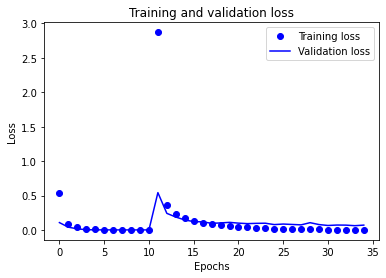

In [46]:
#Plotting the training and validation loss
#It looks perfect
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))


plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

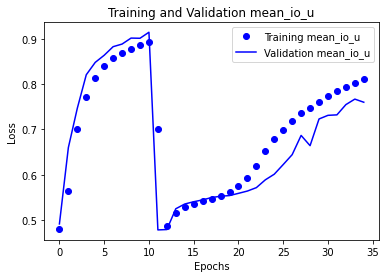

In [44]:
#Plotting the training and validation mean_io_u, looks also good
mean_io_u = history.history['mean_io_u']
val_mean_io_u = history.history['val_mean_io_u']
epochs= range(len(mean_io_u))

plt.plot(epochs, mean_io_u, 'bo', label='Training mean_io_u')
plt.plot(epochs, val_mean_io_u, 'b', label='Validation mean_io_u')
plt.title('Training and Validation mean_io_u')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Prediction')

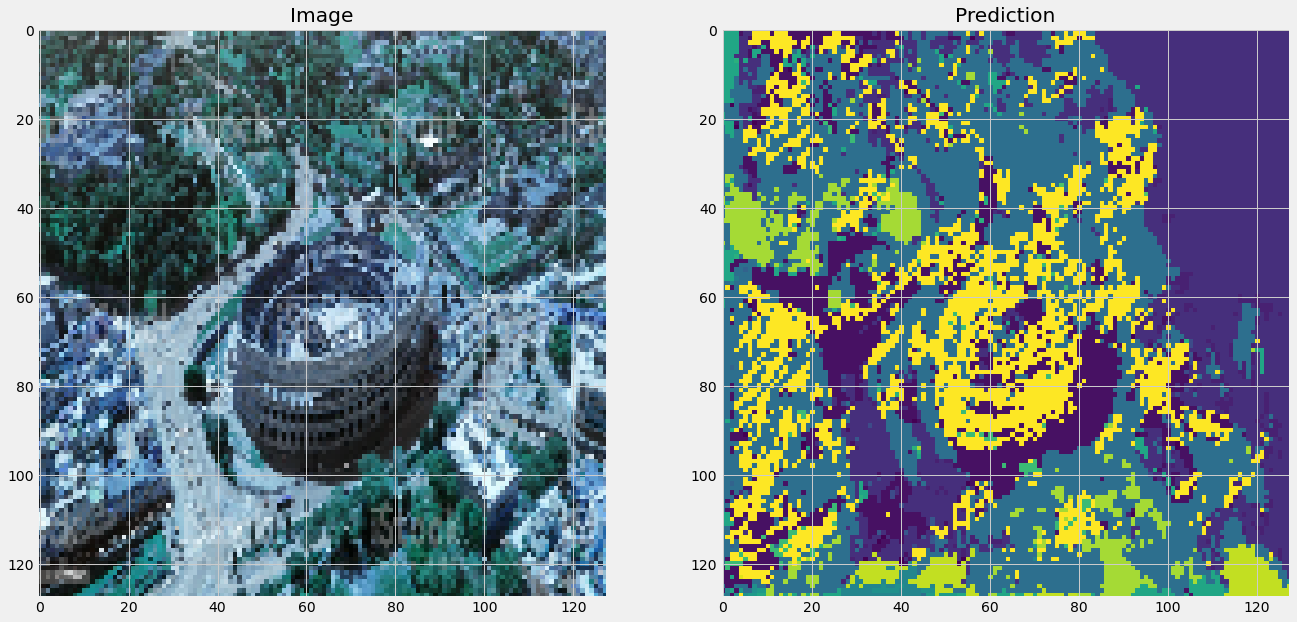

In [107]:
#next step is to test the model with an image
x = cv.imread(r'C:\Users\mohse\Downloads\i.jpg', cv.COLOR_BGR2RGB)
x = cv.resize(x,(128, 128))
pred = model.predict(np.expand_dims(x, 0))
pred = np.argmax(pred, axis=-1)
pred = pred[0]


fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(x)
axs[0].set_title('Original Image')
axs[1].imshow(pred)
axs[1].set_title('The Predicted image')

#We can see that the model is doing good in prediction, note that the images were resized to 128*128 and batch size to 1 due to the computation resources as 
#well as the Unet structure performs better with images with the trained images dimensions 

In [108]:
model.save("my_model.h5") #h5 extension!!

In [ ]:
#Thank you 